# MOACO + robust GPR to estimate ||C(λ)|| (with normalization + log-transform)

In [29]:
import numpy as np
from scipy.optimize import minimize
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel, WhiteKernel
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

##  Step 1: Problem definition

In [34]:
a = np.array([1.0, 2.0, 0.5])
b = np.array([3.0, 0.0, 1.5])

def f1(x): return 0.5 * np.sum((x - a)**2)
def f2(x): return 0.5 * np.sum((x - b)**2)
def scalarized_obj(x, lam): return lam * f1(x) + (1 - lam) * f2(x)

def compute_x_star(lam, x0=np.array([0.0, 0.0, 0.0])):
    res = minimize(scalarized_obj, x0=x0, args=(lam,), method='BFGS')
    return res.x

**Visualize the problem**:

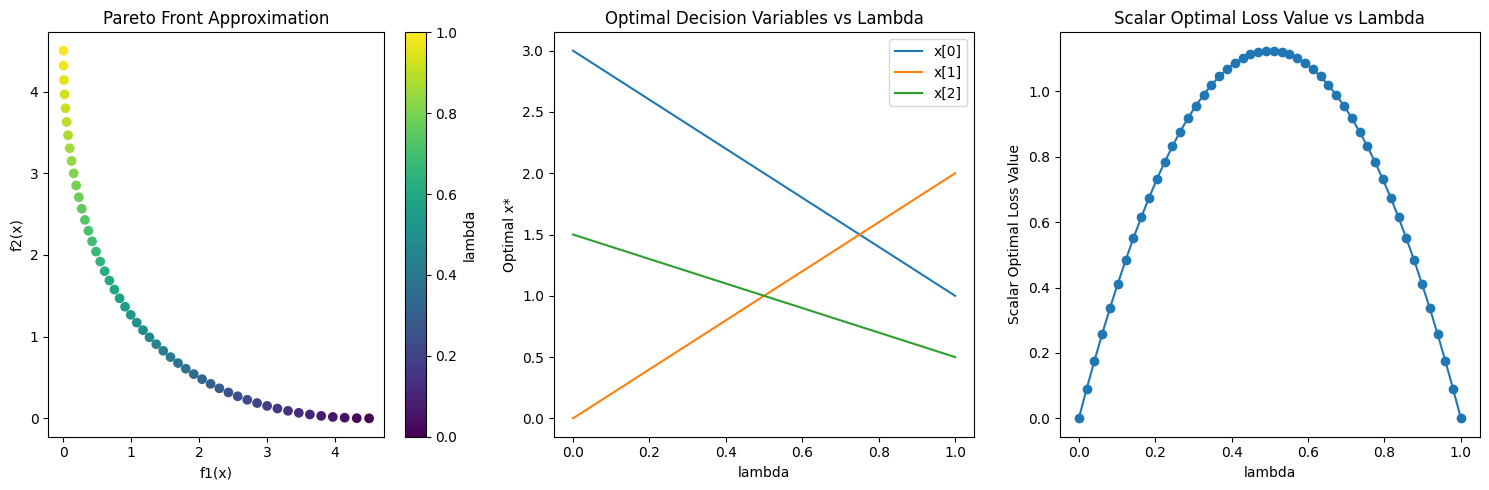

In [35]:
def plot():
    # Generate a set of lambda values in [0, 1]
    lambdas = np.linspace(0, 1, 50)
    x_stars = np.array([compute_x_star(lam) for lam in lambdas])
    f1_vals = np.array([f1(x) for x in x_stars])
    f2_vals = np.array([f2(x) for x in x_stars])
    loss_values = np.array([scalarized_obj(x, lam) for lam, x in zip(lambdas, x_stars)])

    # Create figure for visualizations with 3 subplots
    plt.figure(figsize=(15, 5))

    # Plot 1: Pareto front: f1(x) vs f2(x)
    plt.subplot(1, 3, 1)
    scatter = plt.scatter(f1_vals, f2_vals, c=lambdas, cmap='viridis', marker='o')
    plt.xlabel('f1(x)')
    plt.ylabel('f2(x)')
    plt.title('Pareto Front Approximation')
    plt.colorbar(scatter, label='lambda')

    # Plot 2: Each coordinate of x* versus lambda
    plt.subplot(1, 3, 2)
    for i in range(x_stars.shape[1]):
        plt.plot(lambdas, x_stars[:, i], label=f'x[{i}]')
    plt.xlabel('lambda')
    plt.ylabel('Optimal x*')
    plt.title('Optimal Decision Variables vs Lambda')
    plt.legend()

    # Plot 3: Scalar loss value vs lambda
    plt.subplot(1, 3, 3)
    plt.plot(lambdas, loss_values, marker='o')
    plt.xlabel('lambda')
    plt.ylabel('Scalar Optimal Loss Value')
    plt.title('Scalar Optimal Loss Value vs Lambda')

    plt.tight_layout()
    plt.show()
plot()

## Step 2: Initial dataset

In [45]:
n_initial = 50
lambda_train = np.linspace(0, 1, n_initial).reshape(-1, 1)
x_train = np.array([compute_x_star(lam[0]) for lam in lambda_train])
window_size = 5
frobenius_norms = []
error_per_iter = []


def compute_cov_with_regularization(X, eps=1e-5):
    C = np.cov(X.T)
    if np.linalg.matrix_rank(C) < C.shape[0]:
        C += eps * np.eye(C.shape[0])
    return C

for i in range(n_initial):
    start = max(0, i - window_size // 2)
    end = min(n_initial, i + window_size // 2 + 1)
    local_x = x_train[start:end]
    if local_x.shape[0] < 3:
        C = np.eye(3) * 1e-4
    else:
        C = compute_cov_with_regularization(local_x)
    fro_norm = np.linalg.norm(C, ord='fro')
    frobenius_norms.append(fro_norm)

**Visualization: Lambda vs Frobenius Norm:**

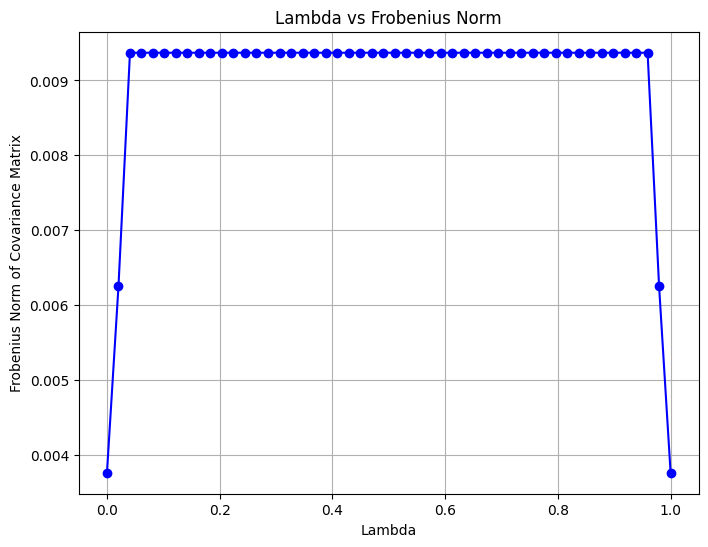

In [46]:

plt.figure(figsize=(8, 6))
plt.plot(lambda_train, frobenius_norms, marker='o', linestyle='-', color='b')
plt.xlabel('Lambda')
plt.ylabel('Frobenius Norm of Covariance Matrix')
plt.title('Lambda vs Frobenius Norm')
plt.grid(True)
plt.show()

## Step 3: Train surrogate model (GPR with normalization and log-transform)

In [47]:
scaler = StandardScaler()
target_scaler = StandardScaler()

X_scaled = scaler.fit_transform(lambda_train)
y_log = np.log1p(frobenius_norms)
y_scaled = target_scaler.fit_transform(np.array(y_log).reshape(-1, 1)).ravel()

kernel = ConstantKernel(1.0, (1e-2, 1e2)) * RBF(1.0, (1e-1, 1e3)) + WhiteKernel(noise_level=1e-3)
model = GaussianProcessRegressor(kernel=kernel, alpha=0.0, normalize_y=False)
model.fit(X_scaled, y_scaled)

GaussianProcessRegressor(alpha=0.0,
                         kernel=1**2 * RBF(length_scale=1) + WhiteKernel(noise_level=0.001))

**Visualize: Surrogate model:**

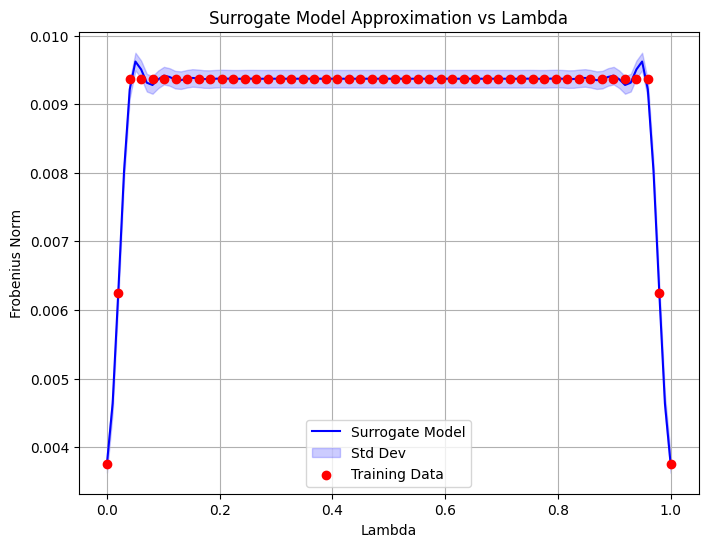

In [48]:
def plot():
    # --- Create a dense lambda grid for prediction ---
    lambda_dense = np.linspace(0, 1, 100).reshape(-1, 1)
    X_dense_scaled = scaler.transform(lambda_dense)
    y_pred_scaled, y_std = model.predict(X_dense_scaled, return_std=True)

    # Inverse the scaling and the log-transform
    y_pred = target_scaler.inverse_transform(y_pred_scaled.reshape(-1, 1)).ravel()
    y_pred_unlog = np.expm1(y_pred)  # inverse of log1p

    # Similarly invert the uncertainty bounds for plotting (approximate)
    y_lower_scaled = y_pred_scaled - y_std
    y_upper_scaled = y_pred_scaled + y_std
    y_lower = target_scaler.inverse_transform(y_lower_scaled.reshape(-1, 1)).ravel()
    y_upper = target_scaler.inverse_transform(y_upper_scaled.reshape(-1, 1)).ravel()
    y_lower_unlog = np.expm1(y_lower)
    y_upper_unlog = np.expm1(y_upper)

    # --- Plot the surrogate model predictions against lambda ---
    plt.figure(figsize=(8, 6))
    plt.plot(lambda_dense, y_pred_unlog, label="Surrogate Model", color="blue")
    plt.fill_between(lambda_dense.ravel(), y_lower_unlog, y_upper_unlog, color='blue', alpha=0.2, label="Std Dev")
    plt.scatter(lambda_train, frobenius_norms, color="red", zorder=5, label="Training Data")
    plt.xlabel("Lambda")
    plt.ylabel("Frobenius Norm")
    plt.title("Surrogate Model Approximation vs Lambda")
    plt.legend()
    plt.grid(True)
    plt.show()
plot()

Iter 1: best λ = 0.95960, value ||C|| = 0.81789
Iter 2: best λ = 0.95960, value ||C|| = 0.82027
Iter 3: best λ = 0.05051, value ||C|| = 0.82237
Iter 4: best λ = 0.05051, value ||C|| = 0.82413
Iter 5: best λ = 0.05051, value ||C|| = 0.82583


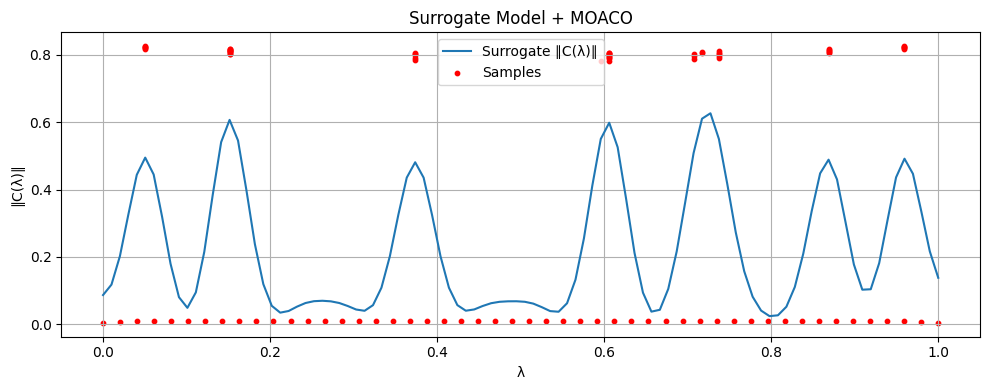

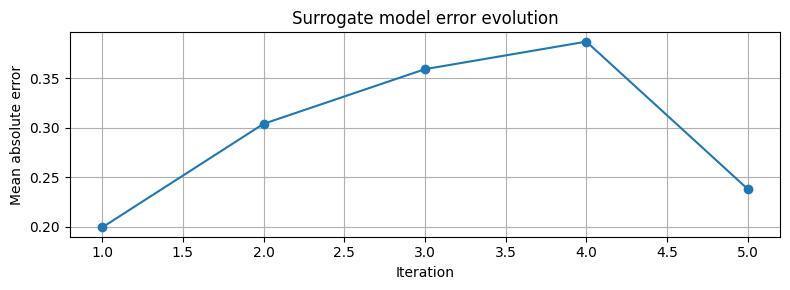

In [49]:

# Step 4: MOACO initialization
n_ants = 10
n_iter = 5
n_grid = 100
rho = 0.2
grid = np.linspace(0, 1, n_grid).reshape(-1, 1)
pheromone = np.ones(n_grid)

# Step 5: MOACO loop
for it in range(n_iter):
    probs = pheromone / pheromone.sum()
    np.random.seed(42)
    selected_idx = np.random.choice(n_grid, size=n_ants, p=probs)
    selected_lambdas = grid[selected_idx]

    # Surrogate prediction (log-norm, scaled)
    X_pred_scaled = scaler.transform(selected_lambdas)
    y_pred_scaled, y_std = model.predict(X_pred_scaled, return_std=True)
    y_pred_log = target_scaler.inverse_transform(y_pred_scaled.reshape(-1, 1)).ravel()
    y_pred = np.expm1(y_pred_log)

    # Compute true values
    new_xs, new_norms = [], []
    for lam in selected_lambdas:
        x_star = compute_x_star(lam[0])
        new_xs.append(x_star)
        local_x = np.vstack((x_train, x_star))
        C_new = compute_cov_with_regularization(local_x)
        norm_C = np.linalg.norm(C_new, ord='fro')
        if norm_C > 500:  
            continue
        new_norms.append(norm_C)


    if len(new_norms) == 0:
        continue

    lambda_train = np.vstack((lambda_train, selected_lambdas[:len(new_norms)]))
    x_train = np.vstack((x_train, new_xs[:len(new_norms)]))
    frobenius_norms.extend(new_norms)

    # Retrain model
    X_scaled = scaler.fit_transform(lambda_train)
    y_log = np.log1p(frobenius_norms)
    y_scaled = target_scaler.fit_transform(np.array(y_log).reshape(-1, 1)).ravel()
    model.fit(X_scaled, y_scaled)

    # Update pheromone
    for idx, val in zip(selected_idx, new_norms):
        pheromone[idx] += val
    pheromone = (1 - rho) * pheromone

    # Mean absolute error
    y_pred_scaled, _ = model.predict(X_scaled, return_std=True)
    y_pred_log = target_scaler.inverse_transform(y_pred_scaled.reshape(-1, 1)).ravel()
    y_pred = np.expm1(y_pred_log)
    error = np.mean(np.abs(np.array(frobenius_norms) - y_pred))
    error_per_iter.append(error)

    print(f"Iter {it+1}: best λ = {selected_lambdas[np.argmax(new_norms)][0]:.5f}, value ||C|| = {max(new_norms):.5f}")

#  Step 6: Visualization
y_final_pred_scaled, _ = model.predict(scaler.transform(grid), return_std=True)
y_final_log = target_scaler.inverse_transform(y_final_pred_scaled.reshape(-1, 1)).ravel()
y_final_pred = np.expm1(y_final_log)

plt.style.use("default")
plt.figure(figsize=(10, 4))
plt.plot(grid, y_final_pred, label='Surrogate ∥C(λ)∥')
plt.scatter(lambda_train, frobenius_norms, color='red', s=10, label='Samples')
plt.xlabel("λ")
plt.ylabel("∥C(λ)∥")
plt.title("Surrogate Model + MOACO")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Step 7: Error visualization
plt.figure(figsize=(8, 3))
plt.plot(range(1, len(error_per_iter)+1), error_per_iter, marker='o')
plt.xlabel("Iteration")
plt.ylabel("Mean absolute error")
plt.title("Surrogate model error evolution")
plt.grid(True)
plt.tight_layout()
plt.show()